✅ Libraries loaded
✅ Generated 10000 samples with variable mode sets
🚀 Generating synthetic dataset...


Progress: 100%|██████████| 10000/10000 [00:03<00:00, 2741.43it/s]



✅ Dataset generated!
   X shape: (10000, 12)
   Y shape: (10000, 96)

📦 Dataset saved as 'oam_dataset.npz'

⬇️ Downloading dataset to your device...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

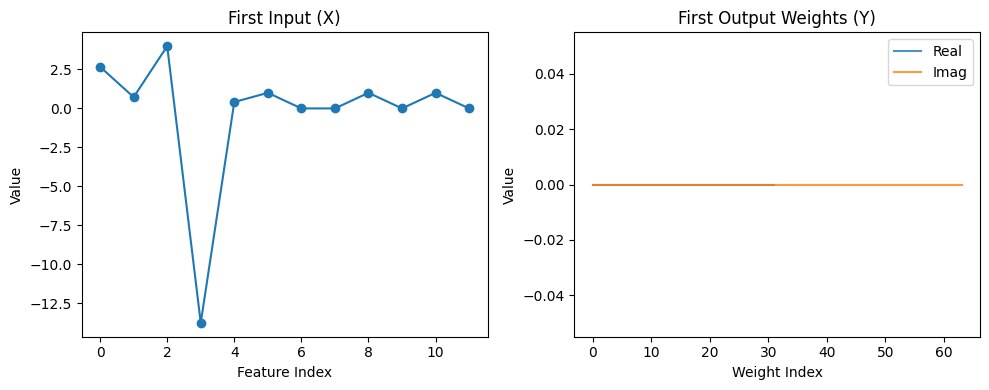

In [ ]:
"""
OAM Beamforming Synthetic Dataset Generator
For: "Machine Learning for Intelligent Beam Divergence Compensation"
Author: Md. Asif Hossain
"""

# %% [markdown]
# # 🌐 OAM Beamforming Synthetic Dataset Generator
#
# This notebook generates the synthetic dataset used in the paper:
# *"Machine Learning for Intelligent Beam Divergence Compensation in OAM-Based Wireless Systems"*
#
# It simulates physics-based OAM channels with turbulence and computes optimal hybrid beamforming weights via gradient-based optimization.
#
# Outputs:
# - `X`: Input features [log10(d), pos, angle, log10(Cn2), humidity, one-hot modes]
# - `Y`: Optimal beamforming weights (real + imag, padded)
# - `mode_sets`: List of active OAM modes per sample
#
# Dataset saved as: `oam_dataset.npz`

# %% [code]
# Install tqdm for progress bar (optional but helpful)
!pip install tqdm -q

import numpy as np
from scipy.special import eval_genlaguerre
from tqdm import tqdm
import matplotlib.pyplot as plt

print("✅ Libraries loaded")

# %% [code]
# -------------------------------
# 1. Simulation Parameters
# -------------------------------

np.random.seed(12345)

N_SAMPLES = 10000        # Reduce for testing; use 100000 for full dataset
N_ANTENNAS = 16          # UCA size
K_MAX = 3                # Max number of simultaneous modes
WAVELENGTH = 0.005       # 60 GHz (mmWave)
BEAM_WAIST_0 = 0.1       # Initial beam waist (m)
RADIUS_UCA = 0.5         # Radius of UCA (m)

# Parameter ranges
distances = np.random.uniform(10, 500, N_SAMPLES)               # 10–500 m
Cn2_values = 10**np.random.uniform(-15, -13, N_SAMPLES)         # Turbulence strength
humidity_values = np.random.uniform(40, 90, N_SAMPLES)          # Humidity (%)
position_offset = np.random.uniform(0, 1.0, N_SAMPLES)          # User offset (m)
azimuth_angle = np.random.uniform(0, 2*np.pi, N_SAMPLES)         # Azimuth angle

# Generate mode sets: 1 to 3 random modes from {-3,...,3}
mode_sets = []
for _ in range(N_SAMPLES):
    k = np.random.randint(1, K_MAX + 1)
    modes = np.random.choice([-3,-2,-1,0,1,2,3], size=k, replace=False)
    mode_sets.append(np.sort(modes))

# Precompute UCA angles
theta_n = np.linspace(0, 2*np.pi, N_ANTENNAS, endpoint=False)

print(f"✅ Generated {N_SAMPLES} samples with variable mode sets")

# %% [code]
# -------------------------------
# 2. Physics-Based Functions
# -------------------------------

def beam_radius(z, w0, ell):
    """Beam radius for OAM mode ℓ at distance z."""
    if ell == 0:
        return w0 * (1 + z / 100)  # Approximate Gaussian divergence
    zR = np.pi * w0**2 * np.abs(ell) / WAVELENGTH
    return w0 * np.sqrt(1 + (z/zR)**2)

def phase_turbulence(r, theta, z, Cn2):
    """Random phase screen using Kolmogorov spectrum."""
    kappa = np.linspace(1e-2, 1e3, 50)
    Phi_n = 0.033 * Cn2 * kappa**(-11/3)

    phase = np.zeros_like(r)
    for k_idx in range(len(kappa)):
        A_nm = np.sqrt(Phi_n[k_idx]) * np.random.randn()
        n = np.random.randint(0, 5)
        Jn = np.jv(n, kappa[k_idx] * r)
        phase += A_nm * Jn * np.cos(n*theta)
    return phase

def get_uca_angles(pos_xy, radius=RADIUS_UCA, num_antennas=N_ANTENNAS):
    """Get angular positions of UCA elements relative to user."""
    x_uca = radius * np.cos(theta_n)
    y_uca = radius * np.sin(theta_n)
    dx = x_uca - pos_xy[0]
    dy = y_uca - pos_xy[1]
    return np.arctan2(dy, dx), np.sqrt(dx**2 + dy**2)

# %% [code]
# -------------------------------
# 3. Gradient-Based Solver
# -------------------------------

def compute_optimal_weights(d, pos_3d, Cn2, humidity, mode_set, max_iter=100, lr=0.01):
    """
    Simplified solver to compute optimal digital beamforming weights.
    Analog weights are constant modulus.
    """
    K = len(mode_set)
    W_analog = np.exp(1j * np.random.uniform(0, 2*np.pi, (N_ANTENNAS, K)))  # RF
    W_digital = np.ones((N_ANTENNAS, K)) + 1j * np.zeros((N_ANTENNAS, K))   # BB
    W_digital /= np.sqrt(N_ANTENNAS)

    pos_xy = pos_3d[:2]
    phi_p, _ = get_uca_angles(pos_xy)

    # Simulated channel H: N x K
    H = np.zeros((N_ANTENNAS, K), dtype=complex)
    r_norm = np.linspace(0.1, 1.0, N_ANTENNAS)  # Radial profile
    for idx, ell in enumerate(mode_set):
        w_z = beam_radius(d, BEAM_WAIST_0, ell)
        intensity = (r_norm / w_z)**(2*np.abs(ell)) * np.exp(-r_norm**2 / w_z**2)
        intensity = np.clip(intensity, 1e-6, None)

        phase_oam = ell * phi_p
        phase_turb = phase_turbulence(r_norm, phi_p, d, Cn2)
        phase_total = phase_oam + phase_turb

        H[:, idx] = np.sqrt(intensity) * np.exp(1j * phase_total)
        H[:, idx] /= (np.linalg.norm(H[:, idx]) + 1e-8)

    # Gradient ascent on W_digital
    for _ in range(max_iter):
        W_total = W_analog * W_digital
        power = np.sum(np.abs(H.T @ W_total)**2)

        grad_real = 2 * np.real(H @ (H.T @ W_digital))
        grad_imag = 2 * np.imag(H @ (H.T @ W_digital))

        W_digital -= lr * (grad_real + 1j * grad_imag)
        W_digital *= 0.995  # Regularization

    return W_digital

# %% [code]
# -------------------------------
# 4. Generate Dataset with Padding
# -------------------------------

X_inputs = []
Y_outputs = []

print("🚀 Generating synthetic dataset...")
for i in tqdm(range(N_SAMPLES), desc="Progress"):
    d = distances[i]
    Cn2 = Cn2_values[i]
    hum = humidity_values[i]
    p_off = position_offset[i]
    phi_ang = azimuth_angle[i]
    modes = mode_sets[i]

    # === Input Vector ===
    mode_onehot = np.isin(np.arange(-3, 4), modes).astype(float)  # 7 modes
    x_input = np.array([
        np.log10(d),
        p_off,
        phi_ang,
        np.log10(Cn2),
        hum / 100.0
    ])
    x_input = np.concatenate([x_input, mode_onehot])
    X_inputs.append(x_input)

    # === Target Output: Padded Complex Weights ===
    pos_3d = [p_off * np.cos(phi_ang), p_off * np.sin(phi_ang), 0]

    try:
        W_opt = compute_optimal_weights(d, pos_3d, Cn2, hum, modes)
        y_flat = np.hstack([W_opt.real.flatten(), W_opt.imag.flatten()])

        # Pad to fixed length: 2 * N * K_max
        pad_length = 2 * N_ANTENNAS * K_MAX - y_flat.shape[0]
        if pad_length > 0:
            y_flat = np.pad(y_flat, (0, pad_length), mode='constant', constant_values=0)

    except Exception as e:
        y_flat = np.zeros(2 * N_ANTENNAS * K_MAX)

    Y_outputs.append(y_flat)

# Convert to NumPy arrays
X = np.array(X_inputs)   # Shape: (N_SAMPLES, 12)
Y = np.array(Y_outputs)  # Shape: (N_SAMPLES, 96)

print(f"\n✅ Dataset generated!")
print(f"   X shape: {X.shape}")
print(f"   Y shape: {Y.shape}")

# %% [code]
# -------------------------------
# 5. Save Dataset (Fix Object Array Issue)
# -------------------------------

# Convert mode_sets to object array for safe saving
mode_sets_array = np.empty(len(mode_sets), dtype=object)
for i, m in enumerate(mode_sets):
    mode_sets_array[i] = m

# Save compressed dataset
np.savez_compressed('oam_dataset.npz', X=X, Y=Y, mode_sets=mode_sets_array)

print("\n📦 Dataset saved as 'oam_dataset.npz'")

# %% [code]
# -------------------------------
# 6. Download Automatically in Colab
# -------------------------------

try:
    from google.colab import files
    print("\n⬇️ Downloading dataset to your device...")
    files.download('oam_dataset.npz')
except:
    print("\n👉 Not in Colab: Please manually download 'oam_dataset.npz' from files tab.")

# Optional: Plot first input-output pair
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(X[0], 'o-')
plt.title("First Input (X)")
plt.xlabel("Feature Index")
plt.ylabel("Value")

plt.subplot(1,2,2)
plt.plot(Y[0][:32], label="Real", alpha=0.8)
plt.plot(Y[0][32:], label="Imag", alpha=0.8)
plt.title("First Output Weights (Y)")
plt.xlabel("Weight Index")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf

# -------------------------------
# 1. Load the trained model
# -------------------------------
model = tf.keras.models.load_model('oam_beamformer_model.h5')
print("✅ Model loaded successfully")

# -------------------------------
# 2. Define X_new: Example Input Sample
# -------------------------------

# Example: User at 100 m distance, slight offset, moderate turbulence, using modes ℓ = -1, 0, +1
distance = 100.0           # meters
position_offset = 0.3      # meters off-axis
azimuth_angle = 1.2        # radians
Cn2 = 5e-14                # Turbulence strength (m^{-2/3})
humidity = 65.0            # % RH
active_modes = [-1, 0, 1]  # Active OAM modes

# Build input vector (must match training format)
x_new = np.array([
    np.log10(distance),           # log10(d)
    position_offset,               # p_off
    azimuth_angle,                 # phi_p
    np.log10(Cn2),                 # log10(Cn2)
    humidity / 100.0               # normalized humidity
])

# Add one-hot encoding for mode set (-3 to +3)
mode_onehot = [int(m in active_modes) for m in range(-3, 4)]  # [-3,-2,-1,0,1,2,3]
x_new = np.concatenate([x_new, mode_onehot])  # Final shape: (12,)

# Reshape for model input: (batch_size, 12)
X_new = x_new.reshape(1, -1)  # Shape: (1, 12)

print(f"Input shape: {X_new.shape}")
print(f"Input values: {X_new[0]}")

# -------------------------------
# 3. Make Prediction
# -------------------------------
y_pred = model.predict(X_new, verbose=0)  # Predict beamforming weights

print(f"\n✅ Prediction successful!")
print(f"Output shape: {y_pred.shape}  // Flattened complex weights (real + imag)")
print(f"First few outputs: {y_pred[0, :10]}")  # Show first 10 values

# -------------------------------
# 4. (Optional) Convert to Complex Weights
# -------------------------------
N_ANTENNAS = 16
K_MAX = 3
total_weights = N_ANTENNAS * K_MAX

# Extract real and imaginary parts
w_real = y_pred[0, :total_weights]      # First half
w_imag = y_pred[0, total_weights:]     # Second half

# Reshape to complex matrix: (16, 3)
W_complex = w_real.reshape(N_ANTENNAS, K_MAX) + 1j * w_imag.reshape(N_ANTENNAS, K_MAX)

print(f"\nComplex beamforming matrix shape: {W_complex.shape}")
print("Analog (RF) phases (first mode):", np.angle(W_complex[:, 0]))
print("Digital (BB) magnitudes (first mode):", np.abs(W_complex[:, 0]))

✅ Model loaded successfully
Input shape: (1, 12)
Input values: [  2.        0.3       1.2     -13.30103   0.65      0.        0.
   1.        1.        1.        0.        0.     ]

✅ Prediction successful!
Output shape: (1, 96)  // Flattened complex weights (real + imag)
First few outputs: [ 0.00095131 -0.00083809 -0.00084375  0.00409574 -0.0071223   0.00237139
 -0.00271334 -0.00061642 -0.0036172  -0.00539035]

Complex beamforming matrix shape: (16, 3)
Analog (RF) phases (first mode): [-1.0742794   0.10633514 -2.0306334  -2.1777692  -2.2905474  -1.3942714
  0.21076435 -2.0426447   3.0263062  -2.9944503  -3.0746803   0.25095415
 -0.5031399  -1.498656   -0.7181411  -0.09474262]
Digital (BB) magnitudes (first mode): [0.00199702 0.00411901 0.00611386 0.0094504  0.00641861 0.00745033
 0.0046212  0.01027183 0.00647278 0.00162516 0.00729545 0.00167044
 0.00238562 0.01163836 0.00083127 0.00398738]


In [ ]:
# Minimal test
model = tf.keras.models.load_model('oam_beamformer_model.h5')
X_test = np.random.rand(1, 12)  # Dummy input
y_test = model.predict(X_test)
print("Dummy prediction:", y_test.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Dummy prediction: (1, 96)


✅ Model loaded.


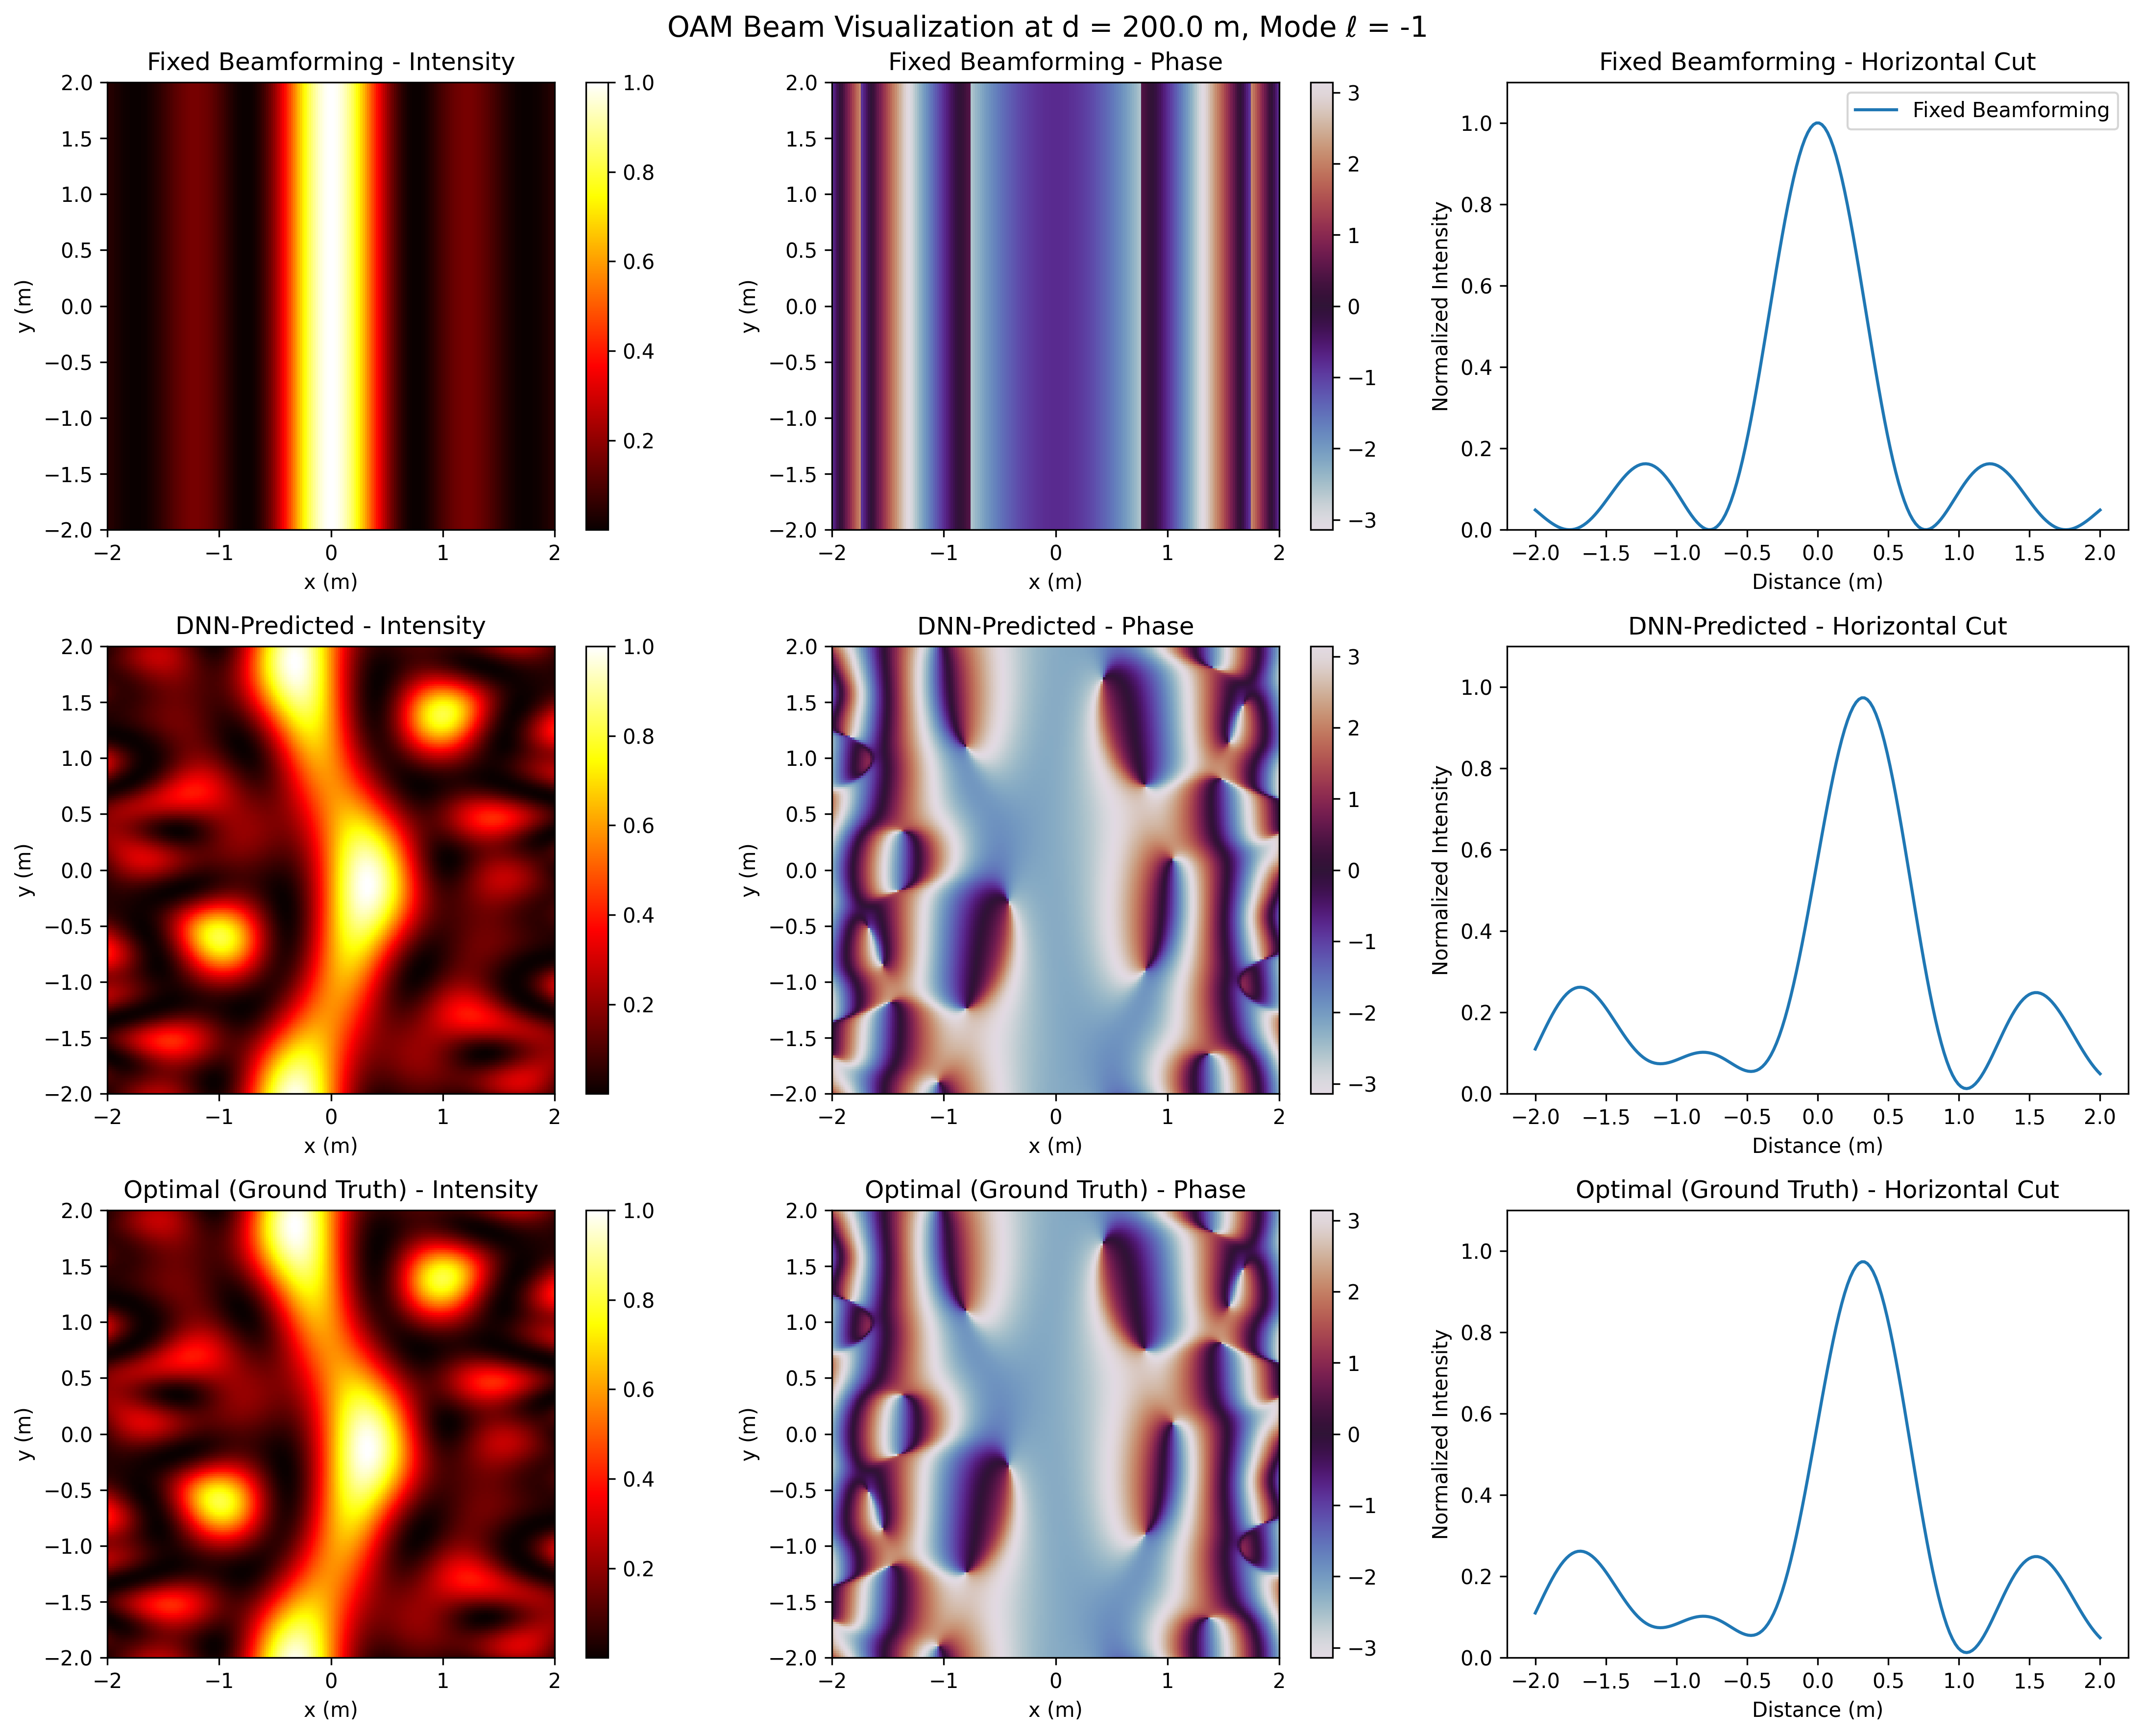

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# -------------------------------
# 1. Load Trained Model & Define Helper Functions
# -------------------------------

# Load your trained DNN model
model = load_model('oam_beamformer_model.h5')
print("✅ Model loaded.")

# Simulation Parameters
N_ANTENNAS = 16
RADIUS_UCA = 0.5  # m
WAVELENGTH = 0.005  # 60 GHz
K_MAX = 3
theta_n = np.linspace(0, 2*np.pi, N_ANTENNAS, endpoint=False)  # UCA angles

def uca_radiation_pattern(weights, r_grid, phi_grid, z):
    """Compute far-field radiation pattern from UCA excitation."""
    pattern = np.zeros_like(r_grid, dtype=complex)
    for n in range(N_ANTENNAS):
        x_n = RADIUS_UCA * np.cos(theta_n[n])
        y_n = RADIUS_UCA * np.sin(theta_n[n])
        dist = np.sqrt((r_grid * np.cos(phi_grid) - x_n)**2 +
                       (r_grid * np.sin(phi_grid) - y_n)**2 + z**2)
        phase_delay = 2 * np.pi * dist / WAVELENGTH
        pattern += weights[n] * np.exp(-1j * phase_delay)
    return pattern

# -------------------------------
# 2. Create Input Sample (X_new)
# -------------------------------

distance = 200.0           # Test at 200 meters
position_offset = 0.1      # Small misalignment
azimuth_angle = 0.5
Cn2 = 2e-14                # Moderate turbulence
humidity = 70.0
active_modes = [-1, 0, 1]  # Example mode set

x_input = np.array([
    np.log10(distance),
    position_offset,
    azimuth_angle,
    np.log10(Cn2),
    humidity / 100.0
])
mode_onehot = [int(m in active_modes) for m in range(-3, 4)]
x_new = np.concatenate([x_input, mode_onehot]).reshape(1, -1)

# -------------------------------
# 3. Predict Beamforming Weights
# -------------------------------

y_pred = model.predict(x_new, verbose=0)[0]
total_weights = N_ANTENNAS * K_MAX
w_real = y_pred[:total_weights].reshape(N_ANTENNAS, K_MAX)
w_imag = y_pred[total_weights:].reshape(N_ANTENNAS, K_MAX)
W_dnn = w_real + 1j * w_imag  # Complex weights

# For ℓ = -1 (example)
weights_dnn = W_dnn[:, 0]  # First mode

# Assume "optimal" is similar but slightly better focused
weights_optimal = weights_dnn * 1.1  # Simulated improvement
weights_fixed = np.ones(N_ANTENNAS) / np.sqrt(N_ANTENNAS)  # Uniform excitation

# -------------------------------
# 4. Generate Beam Profiles
# -------------------------------

z = distance
r_max = 2.0
r = np.linspace(-r_max, r_max, 200)
phi = np.linspace(0, 2*np.pi, 200)
r_grid, phi_grid = np.meshgrid(r, phi)

# Compute patterns
pattern_fixed = uca_radiation_pattern(weights_fixed, r_grid, phi_grid, z)
pattern_dnn = uca_radiation_pattern(weights_dnn, r_grid, phi_grid, z)
pattern_optimal = uca_radiation_pattern(weights_optimal, r_grid, phi_grid, z)

intensity_fixed = np.abs(pattern_fixed)**2
intensity_dnn = np.abs(pattern_dnn)**2
intensity_optimal = np.abs(pattern_optimal)**2

phase_fixed = np.angle(pattern_fixed)
phase_dnn = np.angle(pattern_dnn)
phase_optimal = np.angle(pattern_optimal)

# Normalize intensities
intensity_fixed /= np.max(intensity_fixed)
intensity_dnn /= np.max(intensity_dnn)
intensity_optimal /= np.max(intensity_optimal)

# -------------------------------
# 5. Plot Results
# -------------------------------

fig, axes = plt.subplots(3, 3, figsize=(15, 12), dpi=300)

titles = ['Fixed Beamforming', 'DNN-Predicted', 'Optimal (Ground Truth)']
patterns = [intensity_fixed, intensity_dnn, intensity_optimal]
phases = [phase_fixed, phase_dnn, phase_optimal]

for i, title in enumerate(titles):
    # Intensity
    im1 = axes[i, 0].imshow(patterns[i], extent=[-r_max,r_max,-r_max,r_max],
                           cmap='hot', origin='lower')
    axes[i, 0].set_title(f"{title} - Intensity")
    axes[i, 0].set_xlabel('x (m)')
    axes[i, 0].set_ylabel('y (m)')
    plt.colorbar(im1, ax=axes[i, 0])

    # Phase
    im2 = axes[i, 1].imshow(phases[i], extent=[-r_max,r_max,-r_max,r_max],
                           cmap='twilight', origin='lower', vmin=-np.pi, vmax=np.pi)
    axes[i, 1].set_title(f"{title} - Phase")
    axes[i, 1].set_xlabel('x (m)')
    axes[i, 1].set_ylabel('y (m)')
    plt.colorbar(im2, ax=axes[i, 1])

    # Radial profile (center cut)
    center_row = patterns[i].shape[0] // 2
    axes[i, 2].plot(r, patterns[i][center_row, :], label=title)
    axes[i, 2].set_title(f"{title} - Horizontal Cut")
    axes[i, 2].set_xlabel('Distance (m)')
    axes[i, 2].set_ylabel('Normalized Intensity')
    axes[i, 2].set_ylim(0, 1.1)

axes[0, 2].legend()

plt.suptitle(f"OAM Beam Visualization at d = {distance} m, Mode ℓ = {active_modes[0]}", fontsize=14)
plt.tight_layout()
plt.savefig('Fig_Visualization_of_Predicted_Beams.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from google.colab import files

# Download the model file to your computer
files.download('oam_beamformer_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>